In [1]:
pwd

u'/Users/garyfan/Desktop/1617sem2/STAT4710/Project'

In [2]:
%matplotlib inline

/Users/garyfan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html


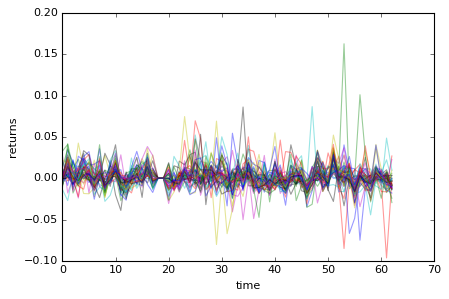

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import pandas.rpy.common as com
import scipy as sp
from rpy2.robjects.packages import importr
flare = importr('flare')
huge = importr('huge')
mass = importr('MASS')

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False
## NUMBER OF ASSETS
n_assets = 50

## NUMBER OF OBSERVATIONS
n_obs = 64
return_df = pd.read_csv('hsi_r_0103.csv', header = 1)
# return_vec = return_df.as_matrix()
plt.plot(return_df, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

In [4]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print rand_weights(n_assets)

[ 0.02775563  0.0114032   0.00904047  0.02197095  0.02867222  0.01686161
  0.03908534  0.02729178  0.01916606  0.01562664  0.0136763   0.02905403
  0.01747795  0.00237828  0.01586283  0.02941053  0.00727265  0.00699209
  0.02118334  0.02119435  0.0252821   0.03385149  0.02887094  0.02435046
  0.02879076  0.01287053  0.01441797  0.00909673  0.01170507  0.02514561
  0.00367056  0.01728382  0.01717071  0.0196743   0.01697016  0.01244421
  0.01699092  0.03560327  0.03762659  0.01999916  0.02486572  0.00460762
  0.01264444  0.01653162  0.03452408  0.00998113  0.01924984  0.03927645
  0.02070248  0.02442502]


In [10]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
    rreturns = com.convert_to_r_dataframe(returns)
    ro.globalenv['x'] = rreturns
    p = np.asmatrix(np.mean(returns, axis=0))
    w = np.asmatrix(rand_weights(returns.shape[1]))
    ro.r('nx = huge.npn(x, npn.func = "shrinkage")')
    ro.r('tiger = sugm(nx,  method = "tiger")')
    ro.r('s = ginv(tiger$icov[[1]])')
    S = com.load_data('s')
    C = np.asmatrix(S)
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
#     p = np.asmatrix(np.mean(returns, axis=0))
#     w = np.asmatrix(rand_weights(returns.shape[1]))
#     C = np.asmatrix(np.cov(returns.T))
#     print w.shape
#     print p.shape
#     print C.shape
    
#     mu = w * p.T
#     sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 20:
        return random_portfolio(returns)
    return mu, sigma

In [11]:
n_portfolios = 200
means, stds = np.column_stack([
    random_portfolio(return_df) 
    for _ in xrange(n_portfolios)
])

Conducting the nonparanormal (npn) transformation via shrunkun ECDF....done.
High-deimensional Sparse Undirected Graphical Models.
Tuning-Insensitive Graph Estimation and Regression.
Conducting the nonparanormal (npn) transformation via shrunkun ECDF....done.
High-deimensional Sparse Undirected Graphical Models.
Tuning-Insensitive Graph Estimation and Regression.
Conducting the nonparanormal (npn) transformation via shrunkun ECDF....done.
High-deimensional Sparse Undirected Graphical Models.
Tuning-Insensitive Graph Estimation and Regression.
Conducting the nonparanormal (npn) transformation via shrunkun ECDF....done.
High-deimensional Sparse Undirected Graphical Models.
Tuning-Insensitive Graph Estimation and Regression.
Conducting the nonparanormal (npn) transformation via shrunkun ECDF....done.
High-deimensional Sparse Undirected Graphical Models.
Tuning-Insensitive Graph Estimation and Regression.
Conducting the nonparanormal (npn) transformation via shrunkun ECDF....done.
High-dei

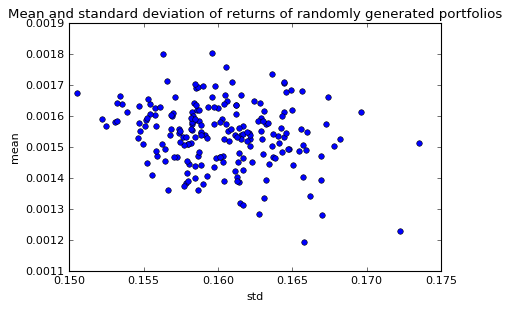

In [12]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

In [16]:
def optimal_portfolio(returns):
    n = returns.shape[1] # len(a) = numrows(a), in the original file len(return_vec) = 4, 
    #no. of stocks. shape[1] returns no. of stocks (50) as well
    rreturns = com.convert_to_r_dataframe(returns)
    ro.globalenv['df'] = rreturns
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
#     ro.r('nx = huge.npn(df, npn.func = "shrinkage")')
#     ro.r('tiger = sugm(nx,  method = "tiger")')
#     ro.r('s = ginv(tiger$icov[[1]])')
#     C = com.load_data('s')
#     S = opt.matrix(np.asmatrix(C))
    S = opt.matrix(np.cov(returns.T))
    pbar = opt.matrix(np.mean(returns, axis=0))
    pbar = pbar.T
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

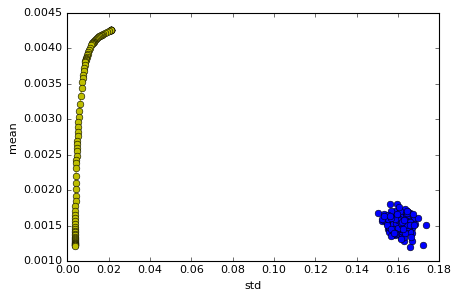

In [17]:
weights, returns, risks = optimal_portfolio(return_df)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [15]:
print weights

[[  5.42032242e-09]
 [  9.80162276e-09]
 [  4.80779896e-09]
 [  2.17833574e-01]
 [  4.34668443e-09]
 [  3.75011809e-09]
 [  6.12791843e-09]
 [  5.35001288e-09]
 [  1.08717186e-08]
 [  9.92165199e-09]
 [  4.63067639e-09]
 [  5.27833709e-09]
 [  2.85596012e-01]
 [  1.00697655e-08]
 [  1.26385130e-08]
 [  2.47438417e-08]
 [  2.38613878e-02]
 [  1.48970787e-08]
 [  6.93054297e-09]
 [  4.24416814e-09]
 [  6.77977914e-09]
 [  9.73454859e-09]
 [  5.73053407e-09]
 [  3.48989030e-09]
 [  6.20411044e-09]
 [  1.68332172e-08]
 [  1.06001986e-08]
 [  6.00153714e-09]
 [  1.06236510e-08]
 [  3.88751822e-09]
 [  3.39265945e-09]
 [  5.98429609e-09]
 [  5.03019254e-09]
 [  6.14248642e-09]
 [  3.96102091e-09]
 [  4.26541989e-09]
 [  1.00077189e-01]
 [  2.97676084e-08]
 [  6.66887160e-09]
 [  8.70133774e-09]
 [  6.69333693e-09]
 [  1.25904904e-08]
 [  7.72776569e-09]
 [  3.72631465e-01]
 [  7.68258474e-09]
 [  6.23033619e-09]
 [  8.85567705e-09]
 [  1.18376830e-08]
 [  5.87969494e-09]
 [  8.03996953e-09]]

In [ ]:
y/